In [1]:
import numpy as np
import mlgrad.models as models
import mlgrad.loss as loss
import mlgrad.funcs as funcs
import mlgrad.risks as risks
import mlgrad.avragg as avragg
# import mlgrad.gd as gd
import mlgrad.funcs2 as funcs2
import mlgrad.weights as weights
from mlgrad.utils import exclude_outliers

import mlgrad.regr as regr
import mlgrad.plots as plots

import pandas as pd
import matplotlib.pyplot as plt

import sys
print(sys.version)

3.12.4 (main, Jul 15 2024, 12:17:32) [GCC 13.3.0]


In [2]:
df = pd.read_csv("data/starsCYG.csv", sep=',', usecols=["log.Te", "log.light"], )

In [3]:
len(df)

47

In [4]:
df

,log.Te,log.light
0,4.37,5.23
1,4.56,5.74
2,4.26,4.93
3,4.56,5.74
4,4.30,5.19
5,4.46,5.46
6,3.84,4.65
7,4.57,5.27
8,4.26,5.57
9,4.37,5.12


In [5]:
Y = df["log.light"].values
X = df["log.Te"].values

X -= np.median(X)
Y -= np.median(Y)

# x_min, x_max = X.min(), X.max()
# X = (X - x_min) / (x_max - x_min)
# y_min, y_max = Y.min(), Y.max()
# Y = (Y - y_min) / (y_max - y_min)

Xs = X.reshape((-1,1))

X0 = np.linspace(X.min(), X.max(), 20)

In [6]:
from sklearn.preprocessing import scale

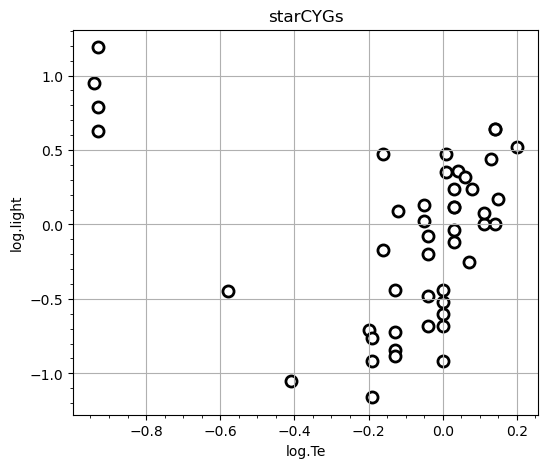

In [7]:
plt.figure(figsize=(6.0, 5.0))
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=2.)
plt.title('starCYGs')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
# plt.xlim(-0.9, 0.6)
# plt.ylim(-2.5, 2.0)
plt.show()

In [8]:
loss_func_sq = loss.ErrorLoss(funcs.Square())
# loss_func_rsq = loss.RelativeErrorLoss(funcs.Square())
loss_func_abs = loss.ErrorLoss(funcs.Absolute())

In [9]:
sqr_norm = funcs2.SquareNorm()

In [10]:
mod_ls = models.LinearModel(1)
mod_ls.init_param()

K=1066 param=[-0.133 -0.412]


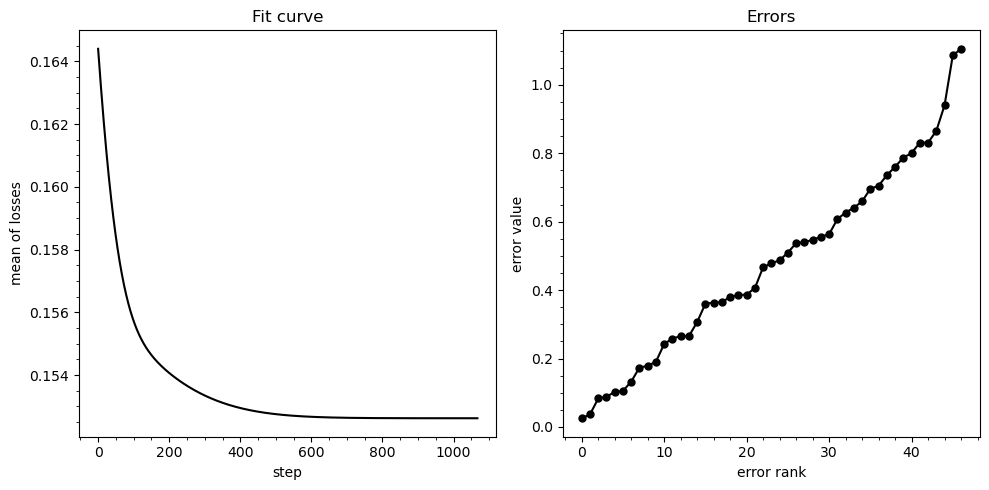

In [11]:
alg_ls = regr.regression(Xs, Y, mod_ls, n_iter=1500, verbose=1)
err_ls = plots.plot_losses_and_errors(alg_ls, Xs, Y)

In [12]:
mod_m_irls = models.LinearModel(1)
mod_m_irls.init_param()

K=14 param=[-0.059  0.990]


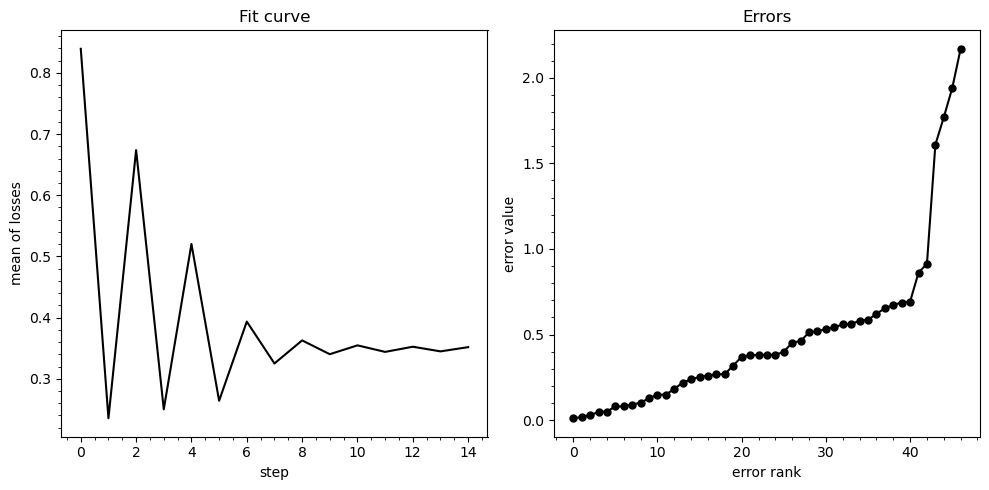

In [13]:
avg_m_irls = regr.averaging_function('M', rhofunc=funcs.Quantile_Sqrt(0.84, 0.001))
alg_m_irls = regr.m_regression_irls(Xs, Y, mod_m_irls, agg_func=avg_m_irls, h=0.001, n_iter2=100, verbose=1)
err_m_irls = plots.plot_losses_and_errors(alg_m_irls, Xs, Y)

In [14]:
mod_wm_irls = models.LinearModel(1)
mod_wm_irls.init_param()

K=5 param=[-0.048  2.546]


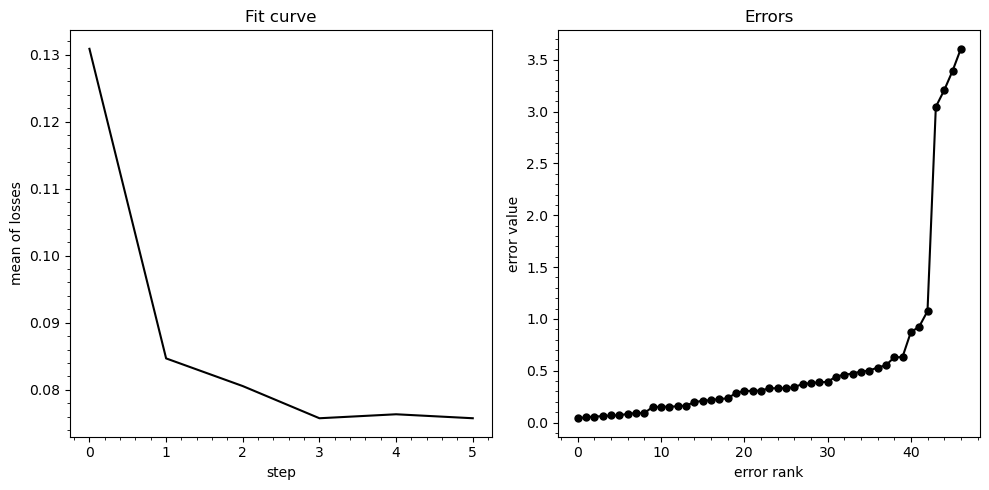

In [15]:
avg_wm_irls = regr.averaging_function('WM', rhofunc=funcs.QuantileFunc(0.85, funcs.SoftAbs_Sqrt(0.001)))
alg_wm_irls = regr.m_regression_irls(Xs, Y, mod_wm_irls, agg_func=avg_wm_irls, h=0.01, n_iter2=70, verbose=1)
err_wm_irls = plots.plot_losses_and_errors(alg_wm_irls, Xs, Y)

In [16]:
mod_wmz_irls = models.LinearModel(1)
mod_wmz_irls.init_param()

K=31 param=[-0.152  3.316]


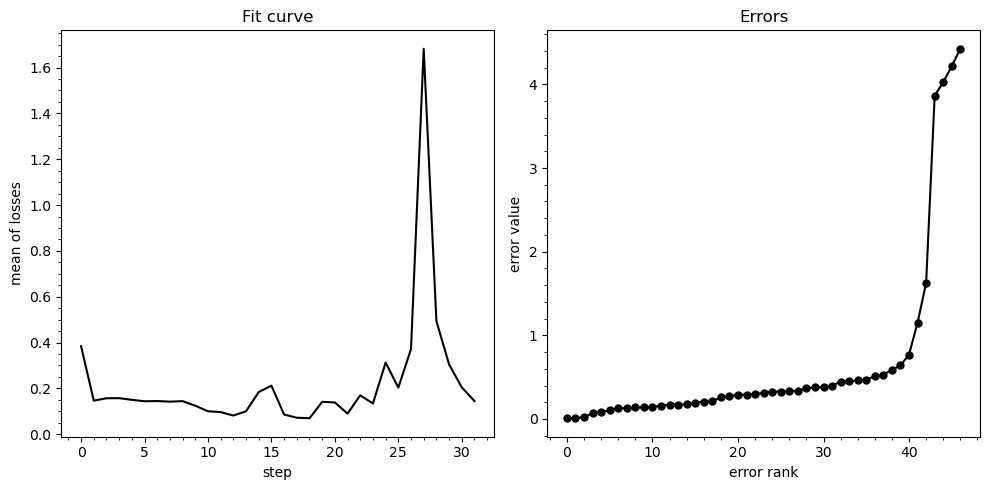

In [17]:
avg_wmz_irls = regr.averaging_function('WMZ', funcs.SoftAbs_Sqrt(0.001), kwds={'tau':3.5})
alg_wmz_irls = regr.m_regression_irls(Xs, Y, mod_wmz_irls, agg_func=avg_wmz_irls, h=0.001,
                                      n_iter2=70, verbose=1)
err_wmz_irls = plots.plot_losses_and_errors(alg_wmz_irls, Xs, Y)

In [18]:
# mod_swm_irls = models.LinearModel(1)
# mod_swm_irls.init_param()

In [19]:
# avg_swm_irls = regr.averaging_function('SWM', rhofunc=funcs.Quantile_Sqrt(0.84, 0.001))
# alg_swm_irls = regr.m_regression_irls(Xs, Y, mod_swm_irls, agg_func=avg_swm_irls, h=0.005, tol=1.0e-8, verbose=1)
# err_swm_irls = plots.plot_losses_and_errors(alg_swm_irls, Xs, Y)

In [20]:
# Err = np.abs(Y - mod2.evaluate_all(Xs))

# X1, X1_ = array_exclude_outliers(X, Err, 7) 
# Y1, Y1_ = array_exclude_outliers(Y, Err, 7) 
# X1s = X1.reshape(-1,1)

In [21]:
mod_r_irls = models.LinearModel(1)
mod_r_irls.init_param()

K=21 param=[-0.015 -0.169]


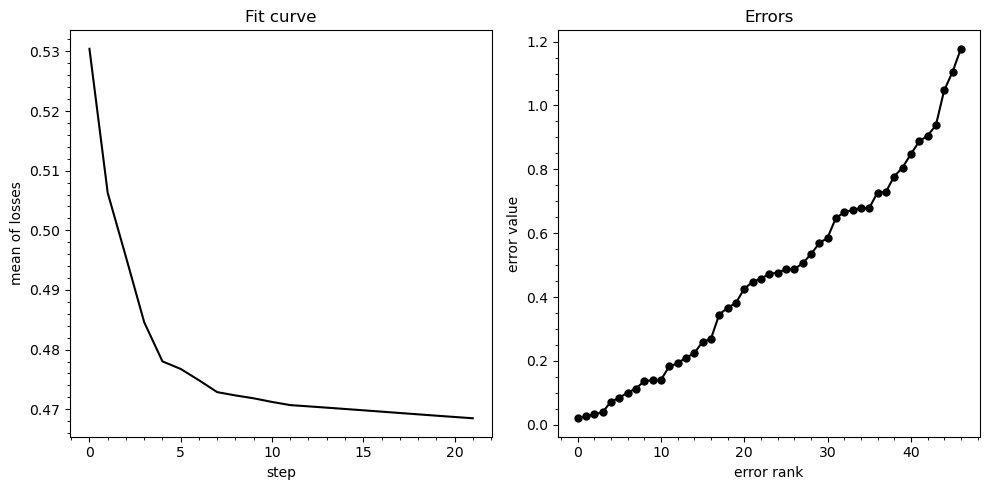

In [22]:
alg_r_irls = regr.r_regression_irls(Xs, Y, mod_r_irls, rho_func=funcs.SoftAbs_Sqrt(0.001), n_iter=1500, verbose=1)
err_r_irls = plots.plot_losses_and_errors(alg_r_irls, Xs, Y)

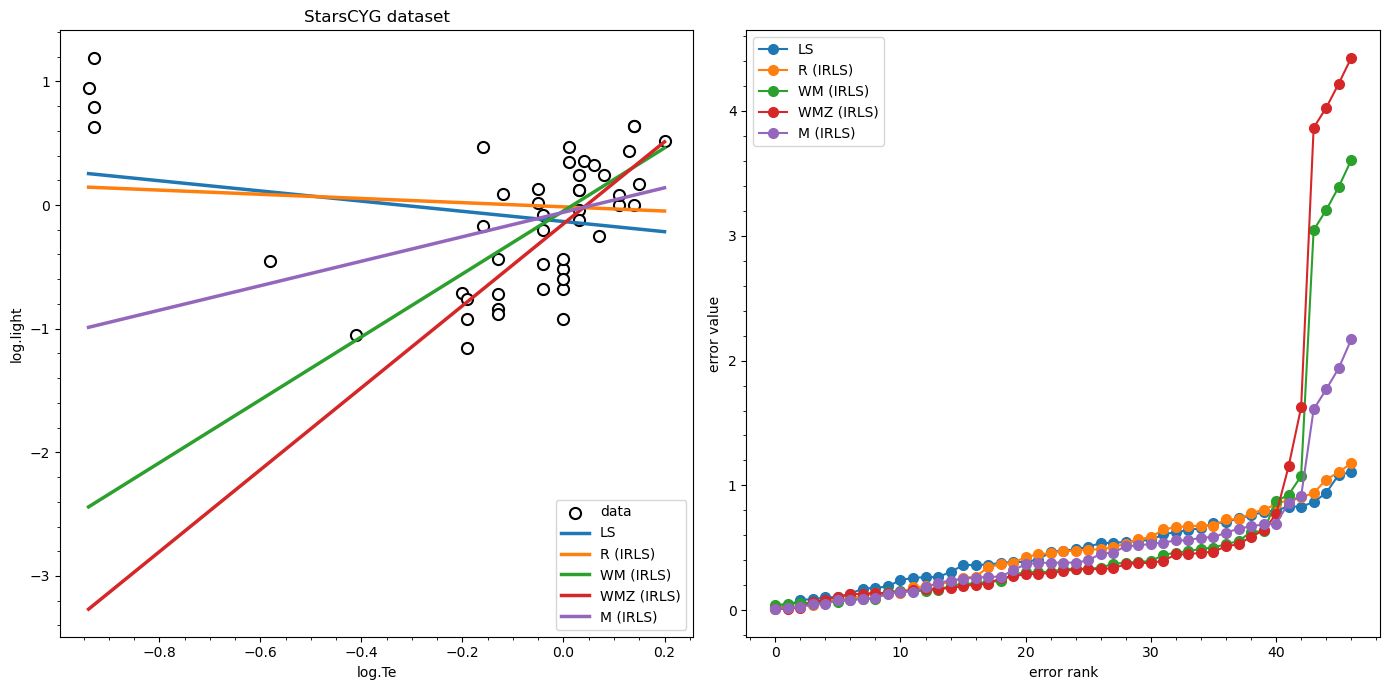

In [23]:
plt.figure(figsize=(14.0, 7.0))
plt.subplot(1,2,1)
plt.title('StarsCYG dataset')
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=1.5, label='data')
plt.plot(X0, mod_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'LS')
plt.plot(X0, mod_r_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'R (IRLS)')
plt.plot(X0, mod_wm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (IRLS)')
plt.plot(X0, mod_wmz_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WMZ (IRLS)')
# plt.plot(X0, mod_wm_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (LS)')
# plt.plot(X0, mod_swm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'SWM (IRLS)')
plt.plot(X0, mod_m_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(sorted(np.abs(Y - mod_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'LS')
plt.plot(sorted(np.abs(Y - mod_r_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'R (IRLS)')
plt.plot(sorted(np.abs(Y - mod_wm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (IRLS)')
plt.plot(sorted(np.abs(Y - mod_wmz_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WMZ (IRLS)')
# plt.plot(sorted(np.abs(Y - mod_wm_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (LS)')
# plt.plot(sorted(np.abs(Y - mod_swm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'SWM (IRLS)')
plt.plot(sorted(np.abs(Y - mod_m_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.ylabel('error value')
plt.xlabel('error rank')
# plt.ylim(-0.1, 4.5)
# plt.xlim(-1, 48)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('fig/starCYGs_plots.jpg')
plt.show()

In [24]:
41/47

0.8723404255319149

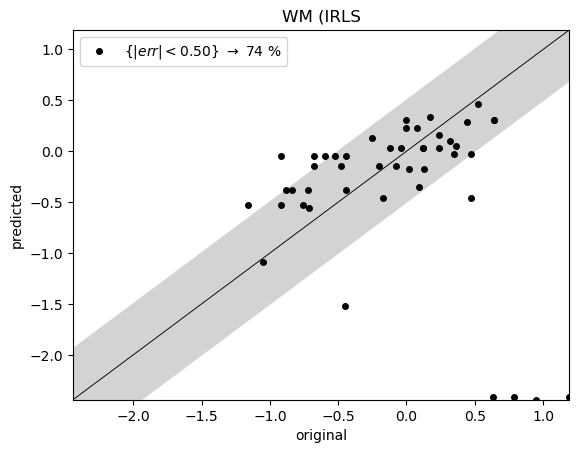

In [25]:
def plot_yy(Xs, Y, mod, label, b=0.1):
    Yp = mod.evaluate_all(Xs)
    E = np.abs(Y - Yp)
    c = sum(E < b) / len(E) * 100
    ymax, ymin = np.max(Y), np.min(Y)
    ypmax, ypmin = np.max(Yp), np.min(Yp)
    ymax = max(ymax, ypmax)
    ymin = min(ymin, ypmin)
    plt.plot([ymin, ymax], [ymin, ymax], color='k', linewidth=0.66)
    plt.fill_between([ymin, ymax], [ymin-b, ymax-b], [ymin+b, ymax+b], color='LightGray')
    plt.scatter(Y, Yp, c='k', s=16, label=r'$\{|err|<%.2f\}\ \to\ %s$ %%' % (b, int(c)))
    plt.title(label)
    plt.ylim(ymin, ymax)
    plt.xlim(ymin, ymax)
    plt.xlabel("original")
    plt.ylabel("predicted")
    plt.legend()

plot_yy(Xs, Y, mod_wm_irls, r'WM (IRLS', 0.5)
plt.show()